# Ce code est la retranscription en Julia du code GGP Matlab.


Voici tout d'abord la liste des imports nécessaires.

Robin Grapin

In [80]:
using SparseArrays
using LinearAlgebra
using Plots
using Statistics
using SuiteSparse
using VectorizedRoutines # for meshgrid

## Les codes suivants sont les fonctions auxiliaires. 

Il faut les exécuter avant d'arriver à la fonction principale ici appelée topggp.

In [81]:
function lgwt(N,a,b) #ok
    # lgwt.m This script is for computing definite integrals using Legendre-Gauss Quadrature.Computes the Legendre - Gauss nodes and weights on an interval [a, b] with truncation order N
    # Suppose you have a continuous function f(x) which is defined on[a, b]  which you can evaluate at any x in [a, b].Simply evaluate itat all of the values contained in the x vector to obtain a vector f.Then compute the definite integral using sum(f. * w);
    # Written by Greg von Winckel - 02 / 25 / 2004
    N = N - 1
    N1 = N + 1
    N2 = N + 2
    xu = range(-1,stop =  1, length =N1)
    xu = xu'

    # Initial guess
    y = cos.((2 * (0:N)'.+1)*pi/(2*N+2)).+(0.27/N1)*sin.(pi*xu*N/N2)
    # Legendre-Gauss Vandermonde Matrix
    L=zeros(N1, N2) 

    # Compute the zeros of the N + 1 Legendre Polynomial using the recursion relation and the Newton - Raphson method
    y0 = 2
    eps = 2.2204e-16
    Lp = 0
    # Iterate until new points are uniformly within epsilon of old points
    while maximum(abs.(y .- y0)) > eps
        L[:, 1].=1
        L[:, 2]=y
        for k = 3:N2
            L[:, k]=((2*(k-1) -1 ) * y[:] .* L[:, k-1] - (k-2) * L[:, k-2] )/ (k-1) ; 
        end
        Lp = N2 * (L[:, N1] - y[:] .* L[:, N2])./ (1 .- y[:].^2);
        y0 = y
        y = y0[:] .- L[:, N2]./ Lp[:];
    end
    # Linear map from [-1, 1] to[a, b]
    x = (a * (1 .- y) + b * (1 .+ y)) / 2
    # Compute the weights
    w = (b - a) ./ ((1 .- y[:].^2) .* Lp[:].^2) * (N2 / N1)^2
    return x, w
end

lgwt (generic function with 1 method)

In [82]:
function acoscplx(x)#prolonge acos sur C
    y = complex(x)
    z = y + im*(1-y*y)^0.5
    return -im*log(z)
end

acoscplx (generic function with 1 method)

In [83]:
function Wgp(x,y,Xc,method = "MMC",alp=1, epsi =0.866, bet=1e-3,r = 0.5)
#  Evaluate characteristic function in each Gauss point
    End = length(Xc)
    ii=1:length(x);   
    X=Xc[1:6:End];
    Y=Xc[2:6:End];
    L=Xc[3:6:End];
    h=Xc[4:6:End];
    T=Xc[5:6:End];
    jj=1:length(X);
    I,J=Matlab.meshgrid(ii,jj)
    xi=reshape(x[I],size(I));
    yi=reshape(y[I],size(I));
    rho=sqrt.((X[J]-xi).^2+(Y[J]-yi).^2);
    drho_dX=(X[J]-xi)./(rho.+(rho==0));
    drho_dY=(Y[J]-yi)./(rho.+(rho==0));
    phi=atan.(-Y[J]+yi,-(X[J]-xi))-T[J]; 
    dphi_dX=((-Y[J]+yi)./(rho.^2 .+(rho==0)));
    dphi_dY=(X[J]-xi)./(rho.^2 .+(rho==0));
    dphi_dT=-ones(size(J));
    upsi=sqrt.(rho.^2+L[J].^2/4-rho.*L[J].*abs.(cos.(phi))).*(((rho.*cos.(phi)).^2) .>=(L[J].^2/4))+ .!(((rho.*cos.(phi)).^2).>=(L[J].^2/4)).*abs.(rho.*sin.(phi));
    dupsi_drho=(2*rho-L[J].*abs.(cos.(phi)))/2 ./(upsi .+(upsi==0)).*((((rho.*cos.(phi)).^2) .>=(L[J].^2/4)))+ .~(((rho.*cos.(phi)).^2) .>=(L[J].^2/4)).*abs.(sin.(phi));
    dupsi_dphi=(L[J].*rho.*sign.(cos.(phi)).*sin.(phi))/2 ./(upsi .+(upsi==0)).*((((rho.*cos.(phi)).^2) .>=(L[J].^2/4)))+ .~(((rho.*cos.(phi)).^2) .>=(L[J].^2/4)).*rho.*sign.(sin.(phi)).*cos.(phi);
    dupsi_dL=(L[J]/2-rho.*abs.(cos.(phi)))./2 ./(upsi .+(upsi==0)).*((((rho.*cos.(phi)).^2) .>=(L[J].^2/4)) .&reshape([ i != 0 for i in upsi],size(upsi)));
    if method =="MMC"
        chi0=1 .-(4*upsi.^2 ./h[J].^2).^alp;
        dchi0_dh=8*alp*upsi.^2 .*(4*upsi.^2 ./h[J].^2).^(alp-1)./h.^3;
        dchi0_dupsi=-8*alp*upsi.*(4*upsi.^2 ./h[J].^2).^(alp-1)./h.^2;
        chi,dchi=Aggregation_Pi(chi0); 
        dchi_dh=(dchi0_dh.*dchi);
        dchi_dupsi=(dchi0_dupsi.*dchi);
        chi[chi .<=-1e6] .=-1e6;#seuil min
        W=(chi .>epsi)+((chi .<=epsi) .& (chi .>=-epsi)).*(3/4*(1-bet)*(chi/epsi .-chi.^3/3/epsi^3).+(1+bet)/2)+(chi .<-epsi)*bet;
        dW_dchi=-3/4*(1/epsi .-chi.^2/epsi^3).*(bet-1).*(abs.(chi) .<epsi);
        dW_dupsi=repeat(dW_dchi,size(dchi_dh,1)).*dchi_dupsi;
        dW_dh=repeat(dW_dchi,size(dchi_dh,1)).*dchi_dh;
        dW_dX=dW_dupsi.*(dupsi_dphi.*dphi_dX+dupsi_drho.*drho_dX);
        dW_dY=dW_dupsi.*(dupsi_dphi.*dphi_dY+dupsi_drho.*drho_dY);
        dW_dL=dW_dupsi.*dupsi_dL;
        dW_dT=dW_dupsi.*dupsi_dphi.*dphi_dT;
    elseif method == "GP" #ok ca marche celui-la
        deltamin=1.0000e-06;
        #r=p.r;
        zetavar=upsi-h[J]/2;
        dzetavar_dupsi=ones(size(upsi));
        dzetavar_dh=-0.5*ones(size(J));
        deltaiel=(1/pi/r^2*(r^2*acoscplx.(zetavar/r))-zetavar.*sqrt.(complex.(r^2 .-zetavar.^2))).*(abs.(zetavar) .<=r)+((zetavar .<-r));
        ddetlaiel_dzetavar=(-2*sqrt.(complex.(r^2 .-zetavar.^2)/pi/r^2)).*(abs.(zetavar) .<=r);
        deltaiel = real.(deltaiel)
        ddetlaiel_dzetavar = real.(ddetlaiel_dzetavar)
        W=deltamin .+(1-deltamin)*deltaiel;
        dW_ddeltaiel=(1-deltamin);
        dW_dh=dW_ddeltaiel*ddetlaiel_dzetavar.*dzetavar_dh;
        dW_dupsi=dW_ddeltaiel*ddetlaiel_dzetavar.*dzetavar_dupsi;
        dW_dX=dW_dupsi.*(dupsi_dphi.*dphi_dX+dupsi_drho.*drho_dX);
        dW_dY=dW_dupsi.*(dupsi_dphi.*dphi_dY+dupsi_drho.*drho_dY);
        dW_dL=dW_dupsi.*dupsi_dL;
        dW_dT=dW_dupsi.*dupsi_dphi.*dphi_dT;
    elseif method == "MNA" #ok
        #epsi=p.sigma;
        epsi = sigma
        ds=upsi;
        d=abs.(upsi);
        l=h[J]/2 .-epsi/2;
        u=h[J]/2 .+epsi/2;
        a3= -2 ./((l - u).*(l.^2 - 2*l.*u + u.^2));
        a2=   (3*(l + u))./((l - u).*(l.^2 - 2*l.*u + u.^2));
        a1=    -(6*l.*u)./((l - u).*(l.^2 - 2*l.*u + u.^2));
        a0=(u.*(- u.^2 + 3*l.*u))./((l - u).*(l.^2 - 2*l.*u + u.^2));
        W=1*(d .<= l)+(a3.*d.^3+a2 .*d.^2+a1.*d+a0).*((d .<=u) .& (d .>l));
        dW_dupsi=sign.(ds).*(3*a3.*d.^2+2*a2 .*d+a1).*((d .<=u) .&(d .>l));
        da3_du=- 2 ./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) - (2*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        da2_du=3 ./((l - u).*(l.^2 - 2*l.*u + u.^2)) + (3*(l + u))./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) + (3*(l + u).*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        da1_du=- (6*l)./((l - u).*(l.^2 - 2*l.*u + u.^2)) - (6*l.*u)./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) - (6*l.*u.*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        da0_du=(- u.^2 + 3*l.*u)./((l - u).*(l.^2 - 2*l.*u + u.^2)) + (u.*(- u.^2 + 3*l.*u))./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) + (u.*(3*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2)) + (u.*(- u.^2 + 3*l.*u).*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        dWf_du=(da3_du.*d.^3+da2_du.*d.^2+da1_du.*d+da0_du).*((d.<=u).&(d.>l));
        da3_dl=2 ./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) + (2*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        da2_dl= 3 ./((l - u).*(l.^2 - 2*l.*u + u.^2)) - (3*(l + u))./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) - (3*(l + u).*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        da1_dl=    (6*l.*u)./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) - (6*u)./((l - u).*(l.^2 - 2*l.*u + u.^2)) + (6*l.*u.*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        da0_dl= (3*u.^2)./((l - u).*(l.^2 - 2*l.*u + u.^2)) - (u.*(- u.^2 + 3*l.*u))./((l - u).^2 .*(l.^2 - 2*l.*u + u.^2)) - (u.*(- u.^2 + 3*l.*u).*(2*l - 2*u))./((l - u).*(l.^2 - 2*l.*u + u.^2).^2);
        dWf_dl=(da3_dl.*d.^3+da2_dl.*d.^2+da1_dl.*d+da0_dl).*((d.<=u).&(d.>l));
        dW_dh=0.5*sign.(ds).*(dWf_du+dWf_dl);
        dW_dX=dW_dupsi.*(dupsi_dphi.*dphi_dX+dupsi_drho.*drho_dX);
        dW_dY=dW_dupsi.*(dupsi_dphi.*dphi_dY+dupsi_drho.*drho_dY);
        dW_dL=dW_dupsi.*dupsi_dL;
        dW_dT=dW_dupsi.*dupsi_dphi.*dphi_dT;
    end
    return W,dW_dX,dW_dY,dW_dT,dW_dL,dW_dh
end
#deltamin= 1.0000e-06
#r=0.5
#sigma = 1
#phi=Wgp(1:20,1:20,1:12)

Wgp (generic function with 6 methods)

In [84]:
# gives m with one occur of each line, and give the indexes of the first occur
#retourne r = (a sans ligne en double) et li; r[li,:]=a
function doublons(m)
    index = []
    #index = zeros(size(m,1))
    m2 = []
    l = length(m[1])
    indexmax = 1
    for i in 1:(size(m,1))
        ligne = m[i,:]
        isin = false
        j = 1
        while j <= size(m2,1)
            if m2[j,:][1]==ligne
                isin = true
                break
            end
            j+=1
        end    
        append!(index,j)
        if !isin
            #println("ca cas, indexmax = ", indexmax)
            push!(m2,ligne)  
            #index[i]=indexmax
            #append!(index,indexmax)
            #indexmax +=1
        #else
            #println("ca cas, j = ", j)
            #index[i ]=j
            #append!(index,j)
        end
    end
    r = zeros(size(m2,1),size(m,2) )

    for i = 1:size(m2,1)

        r[i,:] =m2[i]
    end
    return r,index
end
#e,f=doublons( [10 0 0 0 ; 0 0 0 0 ; 0 0 0 0;10 0 0 0])
#println("f = ",f)
#e[f,:]==[10 0 0 0 ; 0 0 0 0 ; 0 0 0 0;10 0 0 0] 


doublons (generic function with 1 method)

In [85]:
function Aggregation_Pi(z,aggregation ="KSl",ka = 10,zp =1)#penser a mettre en arg les P.qqchose et pour ceux qui ne sont pas dasn ttes les méthodes les mettre en =0 de base
# function that make the aggregation of the values in z and also compute sensitivities
    sz1,sz2 = size(z);
    #zm=repmat(max(z),size(z,1),1) #probleme
    zem = zeros(size(z,2))
    for i = 1:size(z,2)
        zem[i]=maximum(z[:,i])
        #zm[i,:]= [maximum(z[:,j] for j in 1:size(z,2))]
    end
    zeem =zem'
    zm = repeat(zeem,sz1) #tableau des m^colonnes du max de la colonne
    #ka=p.ka; #10
    col = ones(1,sz2)
    
    if aggregation == "asymptotic" #ok
        Wa=sum!(ones(1,sz1),z);
        dWa=ones(size(z));
    elseif aggregation == "boolean" #ok
        Wa=1 .-prod(1 .-z,dims= 1);
        dWa=repeat(prod(1 .-z.* (z .!=1), dims = 1),sz1)./(1 .-z.*(z .!=1));
    
    elseif aggregation == "p-norm"#(sum((z./exp(zm)).^ka,1)).^(1/ka) ptin ca vaut pas pareil sur matlab wtf sinon ok
        #zp=p.zp; #1
        zm=zm .+zp;
        z=z .+zp;          
        Wa=exp.(zm[1,:])'.*(sum!(col,z./exp.(zm).^ka)).^(1/ka) .-zp;
        dWa=(z./exp.(zm)).^(ka-1).*repeat((sum!(col,z./exp.(zm).^ka)).^(1/ka-1),sz1);
    elseif aggregation == "p-mean" #ok,m^prob qu 'en haut a cause des approx, on espere que c est parce que mes exemples sont des gros chiffres
        #zp=p.zp;
        zm=zm .+zp;
        z=z.+zp;
        Wa=exp.(zm[1,:])'.*(mean!(col,(z./exp.(zm)).^ka)).^(1/ka) .-zp;
        dWa=1/size(z,1)^(1/ka)*(z./exp.(zm)).^(ka-1).*repeat(sum!(col,z./exp.(zm).^ka).^(1/ka-1),sz1);
    elseif aggregation == "KS" #ok
        Wa=zm[1,:]'+1/ka*log.(sum!(col,exp.(ka*(z-zm))));
        dWa=exp.(ka*(z-zm))./repeat(sum!(col,exp.(ka*(z-zm))),sz1);
    elseif aggregation == "KSl" #ok
        e = exp.(ka*(z-zm))
        m = mean!(col,e)
        Wa=zm[1,:]' .+1/ka*log.(m);
        dWa=exp.(ka*(z-zm))./repeat(sum!(col,e),sz1);
        else #ok
        e = exp.(ka*(z-zm))
        Wa=sum!(col,z.*e)./sum!(col,e);
        dWa=((e+ka*z.*e).*repeat(sum!(col,e),sz1)-repeat(sum!(col,z.*e),sz1)*ka.*e)./repeat(sum!(col,e).^2,sz1);
        
    end
    return Wa,dWa,z,zm,sz1,ka
end
#Wa,dWa,z,zm,sz1,ka = Aggregation_Pi([10 0 0 0; 0 0 0 0; 1 0 3 0],"ddd")
#z

Aggregation_Pi (generic function with 4 methods)

In [86]:
function fdelta(w,gauss_w,idgp,Ngp,q=1)#pour rendre plus lisible la boucle d'optim
    #delta=sum(reshape(W(:,idgp).*repmat(gauss_weight(:)',size(W,1),1),size(W,1),[],Ngp^2),3)...
     #   ./sum(reshape(repmat(gauss_weight(:)',size(W,1),1),size(W,1),[],Ngp^2),3);
    sz1 = size(w,1)
    agglo_gauss = repeat(gauss_w[:]', sz1)
    n = convert(Int64,length(agglo_gauss)/sz1/(Ngp^2))
    num = reshape(w[:,idgp].^q .*agglo_gauss,sz1,n,Ngp^2) #size a obtenir 18x300x4
    numer = sum!(ones(sz1,n,1),num)
    den = reshape(agglo_gauss, sz1,n,Ngp^2)
    denom = sum!(ones(sz1,n,1),den)
    return reshape(numer ./ denom,sz1,n)
    end # verifier resultats quand on aura certifié que wgt marche bien malgré bug matlab de unique -> ok je crois
#d = fdelta(W,gauss_weight,idgp,Ngp)

fdelta (generic function with 2 methods)

In [87]:
function fdelta_c(w,dw,gauss_w,idgp,Ngp,q,q2)
    sz1 = size(w,1)
    agglo_gauss = repeat(gauss_w[:]', sz1)
    n = convert(Int64,length(agglo_gauss)/sz1/(Ngp^2))
    num = reshape(q*w[:,idgp].^q2 .*dw[:,idgp].*agglo_gauss,sz1,n,Ngp^2) #size a obtenir 18x300x4
    numer = sum!(ones(sz1,n,1),num)
    den = reshape(agglo_gauss, sz1,n,Ngp^2)
    denom = sum!(ones(sz1,n,1),den)
    return reshape(numer ./ denom,sz1,n)
    end # verifier resultats quand on aura certifié que wgt marche bien -> ok je crois

fdelta_c (generic function with 1 method)

In [88]:
function model_updateM(delta,X,method,saturation,aggreg)#verif une fois smooth sat ok
#update the Young Modulus on the base of delta
    m=X[6:6:length(X)];
    nc=length(m);
    m=repeat(m[:],1,size(delta,2));#verif ca
    gammac = 3
    E0 = 1
    if method == "MMC"
        E=E0*delta;
        dE_ddelta=E0*ones(size(delta));
        dE_ddelta=repeat(dE_ddelta,size(m,1),1);
        dE_dm=0*m;
        
    elseif method == "GP"
        hatdelta=delta.*m.^gammac;
        E,dE_dhatdelta=Aggregation_Pi(hatdelta);
        if saturation
            E,ds=smooth_sat(E,nc,aggreg);
            dE_dhatdelta=ds.*dE_dhatdelta;
        end
        E=E.*E0;
        dhatdelta_ddelta=m.^gammac;
        dhatdelta_dm=gammac*delta.*m.^(gammac-1);
        dE_ddelta=E0*dhatdelta_ddelta.*dE_dhatdelta;
        dE_dm=E0*dE_dhatdelta.*dhatdelta_dm;
        
    else #MNA
        hatdelta=delta.*m.^gammac;
        rho,drho_dhatdelta=Aggregation_Pi(hatdelta);
        if saturation
            rho,ds=smooth_sat(rho,nc,aggreg);
            drho_dhatdelta=ds.*drho_dhatdelta;
        end
        E=rho.^penalty.*(E0-Emin)+Emin;
        dhatdelta_ddelta=m.^gammac;
        dhatdelta_dm=gammac*delta.*m.^(gammac-1);
        dE_ddelta=penalty*(E0-Emin)*dhatdelta_ddelta.*drho_dhatdelta.*rho.^(penalty-1);
        dE_dm=penalty*(E0-Emin)*dhatdelta_dm.*drho_dhatdelta.*rho.^(penalty-1);
    end
    return E,dE_ddelta,dE_dm
end

model_updateM (generic function with 1 method)

In [89]:
function smooth_sat(y,nc,aggreg)
    #Smooth saturation function
    #face issues related to aggregation
    if aggreg == "asymptotic"
        xt=1;
    elseif aggreg == "boolean"
        xt=1;
    elseif aggreg == "p-norm"
       xt=1;
    elseif aggreg == "p-mean"
        zp =1
        ka =10
       xt=(((nc-1)*zp^ka+(1+zp)^ka)/nc)^(1/ka)-zp;
    elseif aggreg == "KS"
         xt=1;
    elseif aggreg == "KSl"
        ka =10
         xt=1+1/ka*log.((1+(nc-1)*exp.(-ka))/nc);
    elseif aggreg == "IE"
        ka =10
        xt=1+1/ka*log.((1+(nc-1)*exp.(-ka))/nc);
    end
    pp=100;
    s0=-log(exp(-pp)+1.0./(exp((pp.*0)./xt)+1.0))./pp;
    #s=@(xs,a,pa)(-log(exp(-pa)+1.0./(exp((pa.*xs)./a)+1.0))./pa-s0)/(1-s0);
    #ds=@(xs,a,pa)(exp((pa.*xs)./a).*1.0./(exp((pa.*xs)./a)+1.0).^2)./(a.*(exp(-pa)+1.0./(exp((pa.*xs)./a)+1.0)))/(1-s0);
    s=(-log.(exp.(-pp) .+1.0./(exp.((pp.*y)./xt) .+1.0))./pp .-s0)/(1-s0)
    ds=(exp.((pp.*y)./xt).*1.0./(exp.((pp.*y)./xt) .+1.0).^2)./(xt.*(exp.(-pp) .+1.0./(exp.((pp.*y)./xt) .+1.0)))/(1-s0)
    return s,ds
end

smooth_sat (generic function with 1 method)

In [90]:
function model_updateV(delta,X,method,saturation,aggreg)
# update local densities
    m=X[6:6:length(X)];
    nc=length(m);
    m=repeat(m[:],1,size(delta,2));
    gammav = 1
    if method == "MMC"
        rho=delta;
        drho_ddelta=ones(size(delta));
        drho_ddelta=repmat(drho_ddelta,size(m,1),1);
        drho_dm=0*m;
        
        elseif method == "GP"
        hatdelta=delta.*m.^gammav;
        rho,drho_dhatdelta=Aggregation_Pi(hatdelta);
        if saturation
            rho,ds=smooth_sat(rho,nc,aggreg);
            drho_dhatdelta=ds.*drho_dhatdelta;
        end
        dhatdelta_ddelta=m.^gammav;
        dhatdelta_dm=gammav*delta.*m.^(gammav-1);
        drho_ddelta=dhatdelta_ddelta.*drho_dhatdelta;
        drho_dm=drho_dhatdelta.*dhatdelta_dm;
        
        elseif method == "MNA"
        hatdelta=delta.*m.^gammav;
        rho,drho_dhatdelta=Aggregation_Pi(hatdelta);
        if saturation
            rho,ds=smooth_sat(rho,nc,aggreg);
            drho_dhatdelta=ds.*drho_dhatdelta;
        end
        dhatdelta_ddelta=m.^gammav;
        dhatdelta_dm=gammav*delta.*m.^(gammav-1);
        drho_ddelta=dhatdelta_ddelta.*drho_dhatdelta;
        drho_dm=drho_dhatdelta.*dhatdelta_dm;
    end
    return rho,drho_ddelta,drho_dm
end

model_updateV (generic function with 1 method)

In [91]:
function norato_bar(xi,eta,L,h)
    #a = L/2 .*sqrt.(xi.^2 ./(xi.^2+eta.^2))
    #a+= sqrt.(complex(h.^2/4-L.^2/4 .*eta.^2 ./(xi.^2+eta.^2)))
    #a.*=(xi.^2 ./(xi.^2+eta.^2) .>=(L.^2 ./(h.^2+L.^2)))
    a=h./2 .*sqrt.(complex(1 .+xi.^2 ./(eta.^2 .+(eta==0)))).*((xi.^2 ./(xi.^2+eta.^2) .<(L.^2 ./(h.^2+L.^2))))
    a.*=(xi!=0||eta!=0) .+sqrt(2)/2*h.*(xi==0&&eta==0)
    return real.(a)
   
end

norato_bar (generic function with 1 method)

In [94]:
function norato_bar2(xi,eta,L,h)
    a = L/2 .*sqrt.(xi.^2 ./(xi.^2+eta.^2))
    a+= sqrt.(complex(h.^2/4-L.^2/4 .*eta.^2 ./(xi.^2+eta.^2)))
    a.*=(xi.^2 ./(xi.^2+eta.^2) .>=(L.^2 ./(h.^2+L.^2)))

    return real.(a)
   
end

norato_bar2 (generic function with 1 method)

In [98]:

xi=[[    0.8958    0.9357    0.9663    0.9872    0.9982]
  [  1.0000    0.9948    0.9796    0.9546    0.9201]
   [ 0.7198    0.6469    0.5675    0.4825    0.3926]
    [0.8958    0.9357    0.9663    0.9872    0.9982]
   [-0.9255   -0.9587   -0.9823   -0.9961   -0.9999]]
eta = [   [-0.4444   -0.3527   -0.2575   -0.1598   -0.0604]
    [0.0024    0.1022    0.2010    0.2978    0.3916]
   [ 0.6942    0.7626    0.8234    0.8759    0.9197]
   [-0.4444   -0.3527   -0.2575   -0.1598   -0.0604]
   [ 0.3788    0.2846    0.1874    0.0884   -0.0114]]
L = reshape([    3.0648    3.0648    3.0648    3.0648    3.0648
    6.0993    6.0993    6.0993    6.0993    6.0993
    0.0000    0.0000    0.0000    0.0000    0.0000
    6.4509    6.4509    6.4509    6.4509    6.4509
    5.1896    5.1896    5.1896    5.1896    5.1896],5,5)
h = reshape([1.4415    1.4415    1.4415    1.4415    1.4415
    1.0125    1.0125    1.0125    1.0125    1.0125
   13.6422   13.6422   13.6422   13.6422   13.6422
    1.6671    1.6671    1.6671    1.6671    1.6671
    1.0000    1.0000    1.0000    1.0000    1.0000],5,5)
# expect :     
#    1.6219    1.9107    2.0838    2.1906    2.2444
#    3.5559    3.4326    2.5187    1.7001    1.2928
#    6.8211    6.8211    6.8211    6.8211    6.8211
#    1.8758    2.3632    3.2366    3.8391    4.0300
#    1.3198    1.7571    2.6648    3.0289    3.0937 
a=norato_bar(xi,eta,L,h)
println(a[1,:])
println(a[2,:])
println(a[3,:])
println(a[4,:])
println(a[5,:])
norato_bar2(xi,eta,L,h)

[1.621808327274213, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 2.5186783263998307, 1.699920520703381, 1.2927309442296444]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.875627237182685, 2.3632593340645562, 3.237155259651382, 0.0, 0.0]
[1.3199839556535002, 1.7569420654915717, 0.0, 0.0, 0.0]


5×5 Array{Float64,2}:
 0.0      1.91072  2.08387  2.19059  2.24439
 3.55584  3.43263  0.0      0.0      0.0
 6.8211   6.8211   6.8211   6.8211   6.8211
 0.0      0.0      0.0      3.83911  4.03003
 0.0      0.0      2.66525  3.02892  3.09376

## Transcription de mma : "method of mooving asymptotes"

3 fonctions que l'on utilisera ici, venues du module suivant :

Copyright (C) 2006 Krister Svanberg

    This file, kktcheck.m / mmasub.m / subsolv.m, is part of GCMMA-MMA-code.
    
    GCMMA-MMA-code is free software; you can redistribute it and/or
    modify it under the terms of the GNU General Public License as 
    published by the Free Software Foundation; either version 3 of 
    the License, or (at your option) any later version.
    
    This code is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    
    You should have received a copy of the GNU General Public License
    (file COPYING) along with this file.  If not, see 
    <http://www.gnu.org/licenses/>.
    
    You should have received a file README along with this file,
    containing contact information.  If not, see
    <http://www.smoptit.se/> or e-mail mmainfo@smoptit.se or krille@math.kth.se.

    Version Dec 2006.

In [99]:
function mmasub(m,n,iter,xval,xmin,xmax,xold1,xold2,f0val,df0dx,fval,dfdx,low,upp,a0,a,c,d)# ok fonctionne
    
    epsimin = 10^(-7);
    raa0 = 0.00001;
    move = 0.5;
    albefa = 0.1;
    asyinit = 0.5;
    asyincr = 1.2;
    asydecr = 0.7;
    eeen = ones(n,1);
    eeem = ones(m,1);
    zeron = zeros(n,1);

    # Calculation of the asymptotes low and upp :
    if iter < 2.5
      low = xval - asyinit*(xmax-xmin);
      upp = xval + asyinit*(xmax-xmin);
    else
      zzz = (xval-xold1).*(xold1-xold2);
      factor = eeen;
      #factor(find(zzz > 0)) = asyincr;
      #factor(find(zzz < 0)) = asydecr;
        factor = reshape([ (asyincr*(x > 0) + asydecr*(x<0)) for x in zzz[:] ],size( zzz))
      low = xval - factor.*(xold1 - low);
      upp = xval + factor.*(upp - xold1);
      lowmin = xval - 10*(xmax-xmin);
      lowmax = xval - 0.01*(xmax-xmin);
      uppmin = xval + 0.01*(xmax-xmin);
      uppmax = xval + 10*(xmax-xmin);
      low = max.(low,lowmin);
      low = min.(low,lowmax);
      upp = min.(upp,uppmax);
      upp = max.(upp,uppmin);
    end

    # Calculation of the bounds alfa and beta :

    zzz1 = low + albefa*(xval-low);
    zzz2 = xval - move*(xmax-xmin);
    zzz  = max.(zzz1,zzz2);
    alfa = max.(zzz,xmin);
    zzz1 = upp - albefa*(upp-xval);
    zzz2 = xval + move*(xmax-xmin);
    zzz  = min.(zzz1,zzz2);
    beta = min.(zzz,xmax);

    # Calculations of p0, q0, P, Q and b.

    xmami = xmax-xmin;
    xmamieps = 0.00001*eeen;
    xmami = max.(xmami,xmamieps);
    xmamiinv = eeen./xmami;
    ux1 = upp-xval;
    ux2 = ux1.*ux1;
    xl1 = xval-low;
    xl2 = xl1.*xl1;
    uxinv = eeen./ux1;
    xlinv = eeen./xl1;
    
    p0 = zeron;
    q0 = zeron;
    p0 = max.(df0dx,0);
    q0 = max.(-df0dx,0);
    pq0 = 0.001*(p0 + q0) + raa0*xmamiinv;
    p0 = p0 + pq0;
    q0 = q0 + pq0;
    p0 = p0.*ux2;
    q0 = q0.*xl2;


    P = max.(dfdx,0);
    Q = max.(-dfdx,0);
    P = sparse(P);
    Q = sparse(Q);
    PQ = 0.001*(P + Q) + raa0*eeem*xmamiinv';
    P = P + PQ;
    Q = Q + PQ;
    P = P * sparse(Diagonal(ux2[:,1]))#spdiags(ux2,0,n,n);# fait de la premiere col de ux2 une diag -> sparse(Diagonal(ux2[:,1]))
    Q = Q * sparse(Diagonal(xl2[:,1]))#spdiags(xl2,0,n,n);
    b = P*uxinv + Q*xlinv .- fval ;
    #Solving the subproblem by a primal-dual Newton method
    xmma,ymma,zmma,lam,xsi,eta,mu,zet,s = subsolv(m,n,epsimin,low,upp,alfa,beta,p0,q0,P,Q,a0,a,b,c,d);

    return xmma,ymma,zmma,lam,xsi,eta,mu,zet,s,low,upp
end

mmasub (generic function with 1 method)

In [100]:
function subsolv(m,n,epsimin,low,upp,alfa,beta,p0,q0,P,Q,a0,a,b,c,d)#ok fonctionne
"""
 This function subsolv solves the MMA subproblem:
         
 minimize   SUM[ p0j/(uppj-xj) + q0j/(xj-lowj) ] + a0*z +
          + SUM[ ci*yi + 0.5*di*(yi)^2 ],

 subject to SUM[ pij/(uppj-xj) + qij/(xj-lowj) ] - ai*z - yi <= bi,
            alfaj <=  xj <=  betaj,  yi >= 0,  z >= 0.
        
 Input:  m, n, low, upp, alfa, beta, p0, q0, P, Q, a0, a, b, c, d.
 Output: xmma,ymma,zmma, slack variables and Lagrange multiplers.
"""

    een = ones(n,1);
    eem = ones(m,1);
    epsi = 1;
    epsvecn = epsi*een;
    epsvecm = epsi*eem;
    x = 0.5*(alfa+beta);
    y = eem;
    z = 1;
    lam = eem;
    xsi = een./(x-alfa);
    xsi = max.(xsi,een);
    eta = een./(beta-x);
    eta = max.(eta,een);
    mu  = max.(eem,0.5*c);
    zet = 1;
    s = eem;
    itera = 0;
    while epsi > epsimin
      epsvecn = epsi*een;
      epsvecm = epsi*eem;
      ux1 = upp-x;
      xl1 = x-low;
      ux2 = ux1.*ux1;
      xl2 = xl1.*xl1;
      uxinv1 = een./ux1;
      xlinv1 = een./xl1;
      plam = p0 + P'*lam ;
      qlam = q0 + Q'*lam ;
      gvec = P*uxinv1 + Q*xlinv1;
      dpsidx = plam./ux2 - qlam./xl2 ;
      rex = dpsidx - xsi + eta;
      rey = c .+ d.*y - mu - lam;
      rez = a0 - zet .- a'*lam;
      relam = gvec .- a*z - y + s - b;
      rexsi = xsi.*(x-alfa) - epsvecn;
      reeta = eta.*(beta-x) - epsvecn;
      remu = mu.*y - epsvecm;
      rezet = zet*z - epsi;
      res = lam.*s - epsvecm;
      residu1 = [rex' rey' rez]';
      residu2 = [relam' rexsi' reeta' remu' rezet res']';
      residu = [residu1' residu2']';
      residunorm = sqrt.(residu'*residu)[1,1];
      residumax = maximum(abs.(residu));
      ittt = 0;
      while (residumax > 0.9*epsi) && (ittt < 200)
        ittt=ittt + 1;
        itera=itera + 1;
        ux1 = upp-x;
        xl1 = x-low;
        ux2 = ux1.*ux1;
        xl2 = xl1.*xl1;
        ux3 = ux1.*ux2;
        xl3 = xl1.*xl2;
        uxinv1 = een./ux1;
        xlinv1 = een./xl1;
        uxinv2 = een./ux2;
        xlinv2 = een./xl2;
        plam = p0 + P'*lam ;
        qlam = q0 + Q'*lam ;
        gvec = P*uxinv1 + Q*xlinv1;
        GG = P*sparse(Diagonal(uxinv2[:,1])) -Q*sparse(Diagonal(xlinv2[:,1]))#P*spdiags(uxinv2,0,n,n) - Q*spdiags(xlinv2,0,n,n);
        dpsidx = plam./ux2 - qlam./xl2 ;
        delx = dpsidx - epsvecn./(x-alfa) + epsvecn./(beta-x);
        dely = c .+ d.*y - lam - epsvecm./y;
        delz = a0 .- a'*lam .- epsi/z;
        dellam = gvec .- a*z - y - b .+ epsvecm./lam;
        diagx = plam./ux3 + qlam./xl3;
        diagx = 2*diagx + xsi./(x-alfa) + eta./(beta-x);
        diagxinv = een./diagx;
        diagy = d .+ mu./y;
        diagyinv = eem./diagy;
        diaglam = s./lam;
        diaglamyi = diaglam+diagyinv;
        if m < n
          blam = dellam .+ dely./diagy - GG*(delx./diagx);
          bb = [blam' delz]';
          Alam = sparse(Diagonal(diaglamyi[:,1]))+GG*sparse(Diagonal(diagxinv[:,1]))*GG'#spdiags(diaglamyi,0,m,m) + GG*spdiags(diagxinv,0,n,n)*GG';
          AA = [Alam     a
                a'    -zet/z ];
          solut = AA\bb;
          dlam = solut[1:m];
          dz = solut[m+1];
          dx = -delx./diagx - (GG'*dlam)./diagx;
        else
          diaglamyiinv = eem./diaglamyi;
          dellamyi = dellam + dely./diagy;
          Axx = saprse(Diagonal(diagx[:,1])) + GG'*sparse(Diagonal(diaglamyiinv[:,1]))*GG#spdiags(diagx,0,n,n) + GG'*spdiags(diaglamyiinv,0,m,m)*GG;
          azz = zet/z + a'*(a./diaglamyi);
          axz = -GG'*(a./diaglamyi);
          bx = delx .+ GG'*(dellamyi./diaglamyi);
          bz  = delz .- a'*(dellamyi./diaglamyi);
          AA = [Axx   axz
                axz'  azz ];
          bb = [-bx' -bz]';
          solut = AA\bb;
          dx  = solut[1:n];
          dz = solut[n+1];
          dlam = (GG*dx)./diaglamyi - dz*(a./diaglamyi) + dellamyi./diaglamyi;
        end
    
        dy = -dely./diagy + dlam./diagy;
        dxsi = -xsi .+ epsvecn./(x-alfa) - (xsi.*dx)./(x-alfa);
        deta = -eta .+ epsvecn./(beta-x) + (eta.*dx)./(beta-x);
        dmu  = -mu .+ epsvecm./y - (mu.*dy)./y;
        dzet = -zet .+ epsi/z - zet*dz/z;
        ds   = -s .+ epsvecm./lam - (s.*dlam)./lam;
        xx  = [ y'  z  lam'  xsi'  eta'  mu'  zet  s']';
        dxx = [dy' dz dlam' dxsi' deta' dmu' dzet ds']';
        
        stepxx = -1.01*dxx./xx;
        stmxx  = maximum(stepxx);
        stepalfa = -1.01*dx./(x-alfa);
        stmalfa = maximum(stepalfa);
        stepbeta = 1.01*dx./(beta-x);
        stmbeta = maximum(stepbeta);
        stmalbe  = max.(stmalfa,stmbeta);
        stmalbexx = max.(stmalbe,stmxx);
        stminv = max.(stmalbexx,1);
        steg = 1/stminv;
    
        xold   =   x;
        yold   =   y;
        zold   =   z;
        lamold =  lam;
        xsiold =  xsi;
        etaold =  eta;
        muold  =  mu;
        zetold =  zet;
        sold   =   s;
    
        itto = 0;
        resinew = 2*residunorm;
        while resinew > residunorm && itto < 50
            itto = itto+1;
            x   =   xold + steg*dx;
            y   =   yold + steg*dy;
            z   =   zold + steg*dz;
            lam = lamold + steg*dlam;
            xsi = xsiold + steg*dxsi;
            eta = etaold + steg*deta;
            mu  = muold  + steg*dmu;
            zet = zetold + steg*dzet;
            s   =   sold + steg*ds;
            ux1 = upp-x;
            xl1 = x-low;
            ux2 = ux1.*ux1;
            xl2 = xl1.*xl1;
            uxinv1 = een./ux1;
            xlinv1 = een./xl1;
            plam = p0 + P'*lam ;
            qlam = q0 + Q'*lam ;
            gvec = P*uxinv1 + Q*xlinv1;
            dpsidx = plam./ux2 - qlam./xl2 ;
            rex = dpsidx - xsi + eta;
            rey = c .+ d.*y - mu - lam;
            rez = a0 - zet .- a'*lam;
            relam = gvec .- a*z - y + s - b;
            rexsi = xsi.*(x-alfa) - epsvecn;
            reeta = eta.*(beta-x) - epsvecn;
            remu = mu.*y - epsvecm;
            rezet = zet*z - epsi;
            res = lam.*s - epsvecm;
            residu1 = [rex' rey' rez]';
            residu2 = [relam' rexsi' reeta' remu' rezet res']';
            residu = [residu1' residu2']';
            resinew = sqrt.(residu'*residu)[1,1];
            steg = steg/2;
        end
      residunorm=resinew;
      residumax = maximum(abs.(residu));
      steg = 2*steg;
      end
      if ittt > 198
        epsi
        ittt
      end
    epsi = 0.1*epsi;
    end
    xmma   =   x;
    ymma   =   y;
    zmma   =   z;
    lamma =  lam;
    xsimma =  xsi;
    etamma =  eta;
    mumma  =  mu;
    zetmma =  zet;
    smma   =   s;
    return xmma,ymma,zmma,lamma,xsimma,etamma,mumma,zetmma,smma
end

subsolv (generic function with 1 method)

In [101]:
function kktcheck(m,n,x,y,z,lam,xsi,eta,mu,zet,s,xmin,xmax,df0dx,fval,dfdx,a0,a,c,d)
"""
%  The left hand sides of the KKT conditions for the following
%  nonlinear programming problem are calculated.
%         
%      Minimize  f_0(x) + a_0*z + sum( c_i*y_i + 0.5*d_i*(y_i)^2 )
%    subject to  f_i(x) - a_i*z - y_i <= 0,  i = 1,...,m
%                xmax_j <= x_j <= xmin_j,    j = 1,...,n
%                z >= 0,   y_i >= 0,         i = 1,...,m
%*** INPUT:
%
%   m    = The number of general constraints.
%   n    = The number of variables x_j.
%   x    = Current values of the n variables x_j.
%   y    = Current values of the m variables y_i.
%   z    = Current value of the single variable z.
%  lam   = Lagrange multipliers for the m general constraints.
%  xsi   = Lagrange multipliers for the n constraints xmin_j - x_j <= 0.
%  eta   = Lagrange multipliers for the n constraints x_j - xmax_j <= 0.
%   mu   = Lagrange multipliers for the m constraints -y_i <= 0.
%  zet   = Lagrange multiplier for the single constraint -z <= 0.
%   s    = Slack variables for the m general constraints.
%  xmin  = Lower bounds for the variables x_j.
%  xmax  = Upper bounds for the variables x_j.
%  df0dx = Vector with the derivatives of the objective function f_0
%          with respect to the variables x_j, calculated at x.
%  fval  = Vector with the values of the constraint functions f_i,
%          calculated at x.
%  dfdx  = (m x n)-matrix with the derivatives of the constraint functions
%          f_i with respect to the variables x_j, calculated at x.
%          dfdx(i,j) = the derivative of f_i with respect to x_j.
%   a0   = The constants a_0 in the term a_0*z.
%   a    = Vector with the constants a_i in the terms a_i*z.
%   c    = Vector with the constants c_i in the terms c_i*y_i.
%   d    = Vector with the constants d_i in the terms 0.5*d_i*(y_i)^2.
%     
%*** OUTPUT:
%
% residu     = the residual vector for the KKT conditions.
% residunorm = sqrt(residu'*residu).
% residumax  = max(abs(residu)).
"""
    rex   = df0dx .+ dfdx .* lam - xsi + eta;#pas hyper sûr de .*
    rey   = c .+ d.*y - mu - lam;
    rez   = a0 - zet .- a'*lam;
    relam = fval .- a*z - y + s;
    rexsi = xsi.*(x-xmin);
    reeta = eta.*(xmax-x);
    remu  = mu.*y;
    rezet = zet*z;
    res   = lam.*s;

    residu1 = [rex' rey' rez]';
    residu2 = [relam' rexsi' reeta' remu' rezet res']';
    residu = [residu1' residu2']';
    residunorm = sqrt(residu'*residu);
    residumax = maximum(abs.(residu));
return residu,residunorm,residumax
end

kktcheck (generic function with 1 method)

## Fonction principale

pour l'instant, pour mes tests, je n'ai pas activé la boucle while pour pouvoir vérifier mes resultats après peu d'itérations.

 It.: 1 Obj.: 6861.413025223891 Vol.: 0.1190410472857667 kktnorm.: 10.001 change : 1
 It.: 2 Obj.: 380.42978883056117 Vol.: 0.5467105478018269 kktnorm.: [74.20064899118553] change : 2.4415310542776663
 It.: 3 Obj.: 273.4276488299207 Vol.: 0.6471047672405577 kktnorm.: [109.75918050417073] change : 2.5291635823191183
 It.: 4 Obj.: 5.937210828271276e7 Vol.: 0.4056894225593864 kktnorm.: [299.4132064328549] change : 2.1694043002432557
 It.: 5 Obj.: 529.4140699792581 Vol.: 0.4176622756136033 kktnorm.: [4.673413090938119] change : 2.2453644432897746
 It.: 6 Obj.: 2754.798745779691 Vol.: 0.46443590400606155 kktnorm.: [15.229006140960646] change : 1.5553417846406492
 It.: 7 Obj.: 5.155378536204364e6 Vol.: 0.44147757941670834 kktnorm.: [93.03825232522833] change : 1.9702886503026162
 It.: 8 Obj.: 52.57773133101281 Vol.: 0.6521181246089363 kktnorm.: [10.622866334509421] change : 1.9004787991858136
 It.: 9 Obj.: 195.93977355678683 Vol.: 0.3877334615904248 kktnorm.: [63.6447478705834] change : 1.18

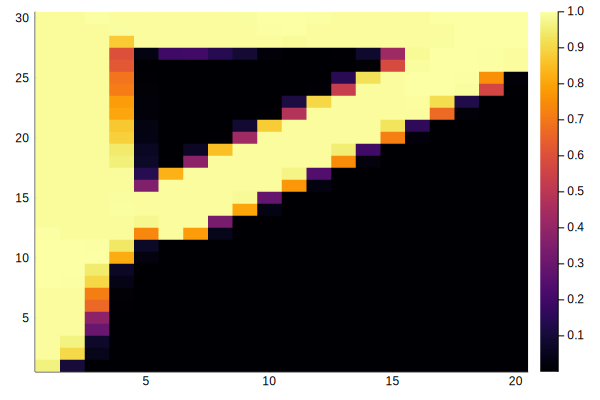

In [115]:
function topggp(nelx,nely,problem = "MBB",settings = "GP" , volfrac = 0.4,maxoutit = 25  )
    starting_guess = "Crosses"
    stopping_criteria="change"  #Stopping Criteria:  'change'  'kktnorm'
    if settings=="GGP"
        method="MMC"   #Method:   'MMC'  'MNA'  'GP'
        q=1                 #q=1
        zp=1           #parameter for p-norm/mean regularization
        alp=1          #parameter for MMC
        epsi=0.866     #parameter for MMC
        bet=1e-3       #parameter for MMC
        minh=1              # minimum height of a component
        aggregation="KSl"   #parameter for the aggregation function to be used
        #'IE'-Induced Exponential  'KS'-KS function  'KSl'-Lowerbound KS function 'p-norm'  'p-mean'
        ka=10          #parameter for the aggregation constant
        saturation=true     #switch for saturation
        ncx=1           #number of components in the x direction
        ncy=1           #number of components in the y direction
        Ngp=2           #number of Gauss point per sampling window
        R=0.5          #radius of the sampling window (infty norm)
        initial_d=0.5    #component initial mass
    elseif settings=="MMC"
        method="MMC"  #'MMC'  'MNA'  'GP'
        q=1                 #q=1
        zp=1           #parameter for p-norm/mean regularization
        alp=1          #parameter for MMC
        epsi=0.866     #parameter for MMC
        bet=1e-3       #parameter for MMC
        minh=1              # minimum height of a component
        aggregation="KSl"  #parameter for the aggregation function to be used
        #'IE'-Induced Exponential  'KS'-KS function  'KSl'-Lowerbound KS function 'p-norm'  'p-mean'
        ka=10          #parameter for the aggregation constant
        saturation=true    #switch for saturation
        ncx=1               #number of components in the x direction
        ncy=1               #number of components in the y direction
        Ngp=2               #number of Gauss point per sampling window
        R=0.5    #radius of the sampling window (infty norm)
        initial_d=0.5         #component initial mass
    elseif settings=="MNA"
        method="MNA"    #'MMC'  'MNA'  'GP'
        q=1             #q=1
        zp=1           #parameter for p-norm/mean regularization
        minh=1              # minimum height of a component
        sigma=1        #parameter for MNA
        penalty=3      #parameter for MNA
        gammav=1       #parameter for GP
        gammac=3       #parameter for GP
        aggregation="KSl"    #parameter for the aggregation function to be used
        #'IE'-Induced Exponential  'KS'-KS function  'KSl'-Lowerbound KS function 'p-norm'  'p-mean'
        ka=10           #parameter for the aggregation constant
        saturation=true     #switch for saturation
        ncx=1               #number of components in the x direction
        ncy=1               #number of components in the y direction
        Ngp=2               #number of Gauss point per sampling window
        R=0.5               #radius of the sampling window (infty norm)
        initial_d=0.5       #component initial mass
    elseif settings=="GP"
        method="GP"    #'MMC'  'MNA'  'GP'
        q=1                 #q=1
        zp=1           #parameter for p-norm/mean regularization
        deltamin=1e-6  #parameter for GP
        r=0.5          #parameter for GP
        minh=1              # minimum height of a component
        gammav=1       #parameter for GP
        gammac=3       #parameter for GP
        aggregation="KSl"  #parameter for the aggregation function to be used
        #'IE'-Induced Exponential  'KS'-KS function  'KSl'-Lowerbound KS function 'p-norm'  'p-mean'
        ka=10          #parameter for the aggregation constant
        saturation=true   #switch for saturation
        ncx=1               #number of components in the x direction
        ncy=1               #number of components in the y direction
        Ngp=2               #number of Gauss point per sampling window
        R=0.5    #radius of the sampling window (infty norm)
        initial_d=0.5       #component initial mass
    else
        print("settings string should be a valid entry: GGP, MMC, MNA or GP") 
        return        
    end
    E=1
    nu=0.3
    E0 = 1;
    Emin = 1e-6
    A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12]
    A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6]
    B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4]
    B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2]
    KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11])
    
        nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx); #number of the nodes in columns
    edofVec = reshape(2*nodenrs[1:end-1,1:end-1].+1,nelx*nely,1) ;#1st dof of each element (x top left)
    edofMat = zeros(nelx*nely, 8); #every line i contains the 8 dof of the ith element
    noeudsvoisins = [0 1 2*nely.+[2 3 0 1] -2 -1];
    for i = 1:8
        for j = 1:nelx*nely
            edofMat[j,i]= edofVec[j]+ noeudsvoisins[i] ;
        end
    end
    iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);# line to build  K
    jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);# columns
    
    # Define the nodal coordinates
    x=1
    Yy=zeros((nelx+1)*(nely+1))
    Xx=zeros((nelx+1)*(nely+1))

    for i = 1:(nelx+1)
        for j = 1:(nely+1)
            Yy[x]= j
            Xx[x]= i
            x+=1
        end
    end
    Yy=(nely+1).-Yy
    Xx=Xx.-1

    
    #only MBB to begin
    fixeddofs = union(1:2:2*(nely+1),[2*(nelx+1)*(nely+1)]);fixednodes=[1:(nely+1);(nelx+1)*(nely+1)];fixed_dir=[ones(nely+1,1);2];
    alldofs = 1:2*(nely+1)*(nelx+1);
    freedofs = setdiff(alldofs,fixeddofs);
    emptyelts=[]; fullelts = [];
    F = zeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1; 
    U = zeros(2*(nely+1)*(nelx+1),1);
"""
    if problem == "MBB"
        excitation_node=1;excitation_direction=2;
        amplitude=-1;
        F = sparse(2*(excitation_node-1)+excitation_direction,1,amplitude,2*(nely+1)*(nelx+1),1);
        fixednodes=[find(Xx==min(Xx));(nelx+1)*(nely+1)];fixed_dir=[ones(nely+1,1);2];
        fixeddofs=2*(fixednodes .-1)+fixed_dir;
        emptyelts=[]; fullelts = [];
    elseif problem == "Short_Cantilever"
        excitation_node=find((Xx==max(Xx))&(Yy==fix(0.5*min(Yy)+0.5*max(Yy))));excitation_direction=2;
        amplitude=-1;
        F = sparse(2*(excitation_node-1)+excitation_direction,1,amplitude,2*(nely+1)*(nelx+1),1);
        fixednodes=repmat(find(Xx==min(Xx)),2,1);fixed_dir=[ones(nely+1,1);2*ones(nely+1,1)];
        fixeddofs=2*(fixednodes-1)+fixed_dir(:);
        emptyelts=[]; fullelts = [];
    elseif problem == "L-shape"
        excitation_node=find((Xx==max(Xx))&(Yy==fix(0.5*min(Yy)+0.5*max(Yy))));excitation_direction=2;
        amplitude=-1;
        F = sparse(2*(excitation_node-1)+excitation_direction,1,amplitude,2*(nely+1)*(nelx+1),1);
        fixednodes=repmat(find(Yy==max(Yy)),2,1);fixed_dir=[ones(nelx+1,1),2*ones(nelx+1,1)];
        fixeddofs=2*(fixednodes-1)+fixed_dir(:);
        emptyelts=find(xc>=(((max(Xx)+min(Xx))/2))&(yc>=((max(Yy)+min(Yy))/2)));
        fullelts = [];
    else
        println("BC string should be a valid entry: ''MBB'',''L-Shape'',''Short_Cantilever'")
        return
    end
"""

        # Compute the centroid coordinates
    xc = zeros(nelx * nely)
    yc = zeros(nelx * nely)
    for xi = 0:(nelx-1)
        xc[(xi*nely+1):(xi+1)*nely].=xi+0.5
    end
    for yi = 0:(nely-1)
        yc[(yi+1):nely:nelx*nely].=yi+0.5
    end
    yc = nely .- yc
              
    centroid_coordinate=zeros(nelx*nely,2)
    for i = 1:nelx*nely
        centroid_coordinate[i,1]= xc[i]
        centroid_coordinate[i,2]= yc[i]
    end
    a=-R
    b=R
    gpc,wc=lgwt(Ngp,a,b)

    gpcx,gpcy=Matlab.meshgrid(gpc,gpc) 
    gauss_w = wc* wc'
    gpcx = repeat( gpcx,nelx*nely)[:] #different results than matlab here?
    gpcy = repeat( gpcy,nelx*nely)[:]
    gauss_weight=repeat(gauss_w,nelx*nely)[:]
    cc=repeat(centroid_coordinate,Ngp^2)
    gauss_point = cc + vcat(gpcx', gpcy')'
    ugp , idgp= doublons(gauss_point)#doublons is my function, encoded higher

    #design variables
    xp=range(minimum(Xx),stop=maximum(Xx),length=ncx+2)
    yp=range(minimum(Yy),stop=maximum(Yy),length=ncy+2); 
    xx,yy=Matlab.meshgrid(xp,yp);
    Xc=repeat(xx[:],2,1);
    Yc=repeat(yy[:],2,1); 
    Lc=2*sqrt.((nelx/(ncx+2))^2+(nely/(ncy+2))^2)*ones(size(Xc)); 
    OnE = ones(convert(Int64,ceil(length(Xc)/2)))
    Tc=atan.(nely/ncy,nelx/ncx)*[OnE;-OnE];# component orientation angle tetha
    hc=2*ones(length(Xc),1); # component h
    Mc=initial_d*ones(size(Xc)); # component mass (For MNA and GP)
    Xg=vcat(Xc',Yc',Lc',hc',Tc',Mc')[:]
    xPhys = zeros(nely, nelx)
    
    #bounds
    Xl=minimum(Xx.-1)*ones(size(Xc));Xu=maximum(Xx.+1)*ones(size(Xc));
    Yl=minimum(Yy.-1)*ones(size(Xc));Yu=maximum(Yy.+1)*ones(size(Xc));
    Ll=0*ones(size(Xc));Lu=sqrt(nelx^2+nely^2)*ones(size(Xc));
    hl=minh*ones(size(Xc));hu=sqrt(nelx^2+nely^2)*ones(size(Xc));
    Tl=-2*pi*ones(size(Xc));Tu=2*pi*ones(size(Xc));
    Ml=0*ones(size(Xc));Mu=ones(size(Xc));
    lower_bound=vcat(Xl',Yl',Ll',hl',Tl',Ml')[:] #ok bonne valeur
    upper_bound=vcat(Xu',Yu',Lu',hu',Tu',Mu')[:] #ok bonne valeur
    X=(Xg-lower_bound)./(upper_bound-lower_bound);
    
    #init MMA : not sure that I use all these parameters-> clean later
    loop = 0;
    m = 1;
    n = length(X);
    epsimin = 0.0000001;
    xval    = X[:];
    xold1   = xval;
    xold2   = xval;
    xmin    = zeros(n);
    xmax    = ones(n);
    low     = xmin;
    upp     = xmax;
    C       = 1000*ones(m);
    d       = zeros(m);
    a0      = 1;
    a       = zeros(m);
    outeriter = 0;
    kkttol  =0.001;
    changetol=0.001;
    kktnorm = kkttol+10;
    outit = 0;
    change=1;
    
    cvec=zeros(maxoutit);
    vvec=zeros(maxoutit);
    #ovvec=cvec;gvec=cvec;pvec=cvec;#for storage and plots
    plot_rate=10;
    
    #for plots
    tt=0:0.1:(2*pi);tt=repeat(tt,1,length(Xc))';
    cc=cos.(tt);ss=sin.(tt);
    
    if stopping_criteria == "kktnorm"
        stop_cond=outit < maxoutit && kktnorm>kkttol;
    else
        stop_cond=outit < maxoutit &&change>changetol;
    end
    
    #design loop
    while  stop_cond 
        outit   = outit+1;
        outeriter = outeriter+1;
        #Compute the smooth characteristic functions and gradients for each component 
        # on each sampling window Gauss point (Can support GPU)
        W,dW_dX,dW_dY,dW_dT,dW_dL,dW_dh=Wgp(ugp[:,1],ugp[:,2],Xg,settings); #l183 matlab, here we get W different than in matlab code
        #Compute local volume fractions and gradients using generalized projection
        # delta is for densities, deltac for Young modulus
        #for next arrays : not same size than matlab because my "doublons" is working differently than matlab's one
        delta = fdelta(W,gauss_weight,idgp,Ngp)
        ddelta_dX = fdelta(dW_dX,gauss_weight,idgp,Ngp)
        ddelta_dY = fdelta(dW_dY,gauss_weight,idgp,Ngp)
        ddelta_dT = fdelta(dW_dT,gauss_weight,idgp,Ngp)
        ddelta_dL = fdelta(dW_dL,gauss_weight,idgp,Ngp)
        ddelta_dh = fdelta(dW_dh,gauss_weight,idgp,Ngp)
        delta_c = fdelta(W,gauss_weight,idgp,Ngp,q) # q = 1 donc ptetre a optim plus tard...
        ddelta_c_dX = fdelta_c(W,dW_dX,gauss_weight,idgp,Ngp,q,q-1)
        ddelta_c_dY = fdelta_c(W,dW_dY,gauss_weight,idgp,Ngp,q,q-1)
        ddelta_c_dT = fdelta_c(W,dW_dT,gauss_weight,idgp,Ngp,q,q-1)
        ddelta_c_dL = fdelta_c(W,dW_dL,gauss_weight,idgp,Ngp,q,q-1)
        ddelta_c_dh = fdelta_c(W,dW_dh,gauss_weight,idgp,Ngp,q,q-1)

        E,dE,dE_dm=model_updateM(delta_c,X,method,saturation,aggregation);#X l167
        dE_dX=dE.*ddelta_c_dX;
        dE_dY=dE.*ddelta_c_dY;
        dE_dT=dE.*ddelta_c_dT;
        dE_dL=dE.*ddelta_c_dL;
        dE_dh=dE.*ddelta_c_dh;
        E=reshape(E[:],nely,nelx);#full removed, a enlever ?

        #compute densities
        rho,drho_ddelta,drho_dm=model_updateV(delta,X,method,saturation,aggregation);
        drho_dX=drho_ddelta.*ddelta_dX;
        drho_dY=drho_ddelta.*ddelta_dY;
        drho_dT=drho_ddelta.*ddelta_dT;
        drho_dL=drho_ddelta.*ddelta_dL;
        drho_dh=drho_ddelta.*ddelta_dh;
        xPhys=reshape(rho[:],nely,nelx);#full removed again
        
        #Take in account passive elements
        xPhys[emptyelts] .= 0;
        xPhys[fullelts] .= 1;
        E[emptyelts] .= Emin;
        E[fullelts] .= E0;

        # FE-ANALYSIS
        sK = reshape(KE[:]*(E[:]'),64*nelx*nely,1);
        K = sparse(iK[:],jK[:],sK[:]); K = (K+K')/2;
        U[freedofs] = K[freedofs,freedofs]\F[freedofs];#pas exactement pareil que matlab

        # OBJECTIVE FUNCTION AND SENSITIVITY ANALYSIS
        edM = [convert(Int64,i) for i in edofMat] ;#to index by int
        v = (U[edM]*KE).*U[edM]
        ce = reshape(sum!(ones(size(v,1)),v),nely,nelx);
        c = sum(E.*ce);
        v=mean(xPhys);

        dc_dE = -ce;
        dc_dE[emptyelts] .= 0;
        dc_dE[fullelts] .= 0;
        dc_dX=dE_dX*dc_dE[:]
        dc_dY=dE_dY*dc_dE[:]
        dc_dL=dE_dL*dc_dE[:]
        dc_dh=dE_dh*dc_dE[:]
        dc_dT=dE_dT*dc_dE[:]
        dc_dm=dE_dm*dc_dE[:]
        lll = length(X)
        dc=zeros(size(X));
        dc[1:6:lll]=dc_dX;
        dc[2:6:lll]=dc_dY;
        dc[3:6:lll]=dc_dL;
        dc[4:6:lll]=dc_dh;
        dc[5:6:lll]=dc_dT;
        dc[6:6:lll]=dc_dm;
        dv_dxPhys = ones(nely,nelx)/nelx/nely;
        dv_dxPhys[emptyelts] .= 0;
        dv_dxPhys[fullelts] .= 0;
        dv_dX=drho_dX*dv_dxPhys[:]
        dv_dY=drho_dY*dv_dxPhys[:]
        dv_dL=drho_dL*dv_dxPhys[:]
        dv_dh=drho_dh*dv_dxPhys[:]
        dv_dT=drho_dT*dv_dxPhys[:]
        dv_dm=drho_dm*dv_dxPhys[:]
        dv=zeros(size(X));
        dv[1:6:lll]=dv_dX;
        dv[2:6:lll]=dv_dY;
        dv[3:6:lll]=dv_dL;
        dv[4:6:lll]=dv_dh;
        dv[5:6:lll]=dv_dT;
        dv[6:6:lll]=dv_dm;

        # store the output for plot
        cvec[outit]=c;vvec[outit]=v;
        println(" It.: ",outit , " Obj.: ",c ," Vol.: ",mean(xPhys[:]), " kktnorm.: ", kktnorm," change : ",change);

        # pass scaled objective and constraint function and sensitivities to MMA
        f0val=log(c+1); #valeur ok
        fval=[(v-volfrac)/volfrac]*100; 
        df0dx=(dc[:]/(c+1).*(upper_bound[:]-lower_bound[:])); 
        dfdx=(dv[:]'/volfrac)*100 .*(upper_bound[:]-lower_bound[:])';


        ##partie mmasub (ligne 366 à 385 du main)
        X,ymma,zmma,lam,xsi,eta,mu,zet,S,low,upp=mmasub(m,n,outeriter,xval,xmin,xmax,xold1,xold2, f0val,df0dx,fval,dfdx,low,upp,a0,a,C,d);
        xold2 = xold1;
        xold1 = xval;
        xval  = X;
        Xg=lower_bound+(upper_bound-lower_bound).*X;
        change=norm(xval .-xold1);
        #The residual vector of the KKT conditions is calculated:
        residu,kktnorm,residumax = kktcheck(m,n,X,ymma,zmma,lam,xsi,eta,mu,zet,S, xmin,xmax,df0dx,fval,dfdx[:],a0,a,C,d);

    
        # update the stopping criterion 
        if stopping_criteria == "kktnorm"
            stop_cond=outit < maxoutit && kktnorm>kkttol;
        else
            stop_cond=outit < maxoutit &&change>changetol;
        end
  
    end #du while
        #if(rem(outit, plot_rate)==0) #plot one pic every plot_rate, not activated so far to have only the interesting result at the end
    #component plot
    
    longXg = length(Xg)
    Xc=Xg[1:6:longXg];
    Yc=Xg[2:6:longXg];
    Lc=Xg[3:6:longXg];
    hc=Xg[4:6:longXg];
    Tc=Xg[5:6:longXg];
    Mc=Xg[6:6:longXg];

    C0=repeat(cos.(Tc),1,size(cc,2));
    S0=repeat(sin.(Tc),1,size(cc,2));
    xxx=repeat(Xc[:],1,size(cc,2))+cc;
    yyy=repeat(Yc[:],1,size(cc,2))+ss;

    xi=C0.*(xxx .-Xc)+S0.*(yyy .-Yc);
    Eta=-S0.*(xxx .-Xc)+C0.*(yyy .-Yc);

    Lrep = repeat(Lc[:],1,size(cc,2))
    hrep = repeat(hc[:],1,size(cc,2))
    dd=norato_bar(xi,Eta,Lrep,hrep) + norato_bar2(xi,Eta,Lrep,hrep);
    xn=repeat(Xc,1,size(cc,2))+dd.*cc;
    yn=repeat(Yc,1,size(cc,2))+dd.*ss;
    tolshow=0.1;

    Shown_compo=[i for i in 1:length(Mc) if Mc[i]>tolshow ]#find(Mc>tolshow);
    
    """
        if strcmp(BC,'L-shape')
            fill([fix((min(Xx)+max(Xx))/2),max(Xx),max(Xx),fix((min(Xx)+max(Xx))/2)],[fix((min(Yy)+max(Yy))/2),...
                fix((min(Yy)+max(Yy))/2),max(Yy),max(Yy)],'w')
        end
    """
    """
        caxis([0,1])
        colormap 'jet'
        axis equal; axis off;
        hold on
        scatter(Xx(fixednodes(fixed_dir==1)),Yy(fixednodes(fixed_dir==1)),'>b','filled')
        scatter(Xx(fixednodes(fixed_dir==2)),Yy(fixednodes(fixed_dir==2)),'^b','filled')
        scal=10;
        quiver(Xx(excitation_node),Yy(excitation_node)+scal*(excitation_direction==2),excitation_direction==1,...
            -(excitation_direction==2),scal,'r','Linewidth',2)# fleche la ou on applique l'effort
        colorbar
        axis([min(Xx),max(Xx),min(Yy),max(Yy)])
        print([Path,'component_',num2str(outit-1,'%03d')],'-dpng')
        hold off
    end du if
    """
    #end du while a mettre ici si je veux faire des plots réguliers
    return outit, vvec,cvec, xPhys, xn , yn, Shown_compo,Xx[fixednodes],Yy[fixednodes]
end
outit, vvec,cvec, xPhys, xn,yn,Shown_compo,Xf,Yf= topggp(20,30,"MBB","GP" ,  0.4, 50)

heatmap(xPhys)

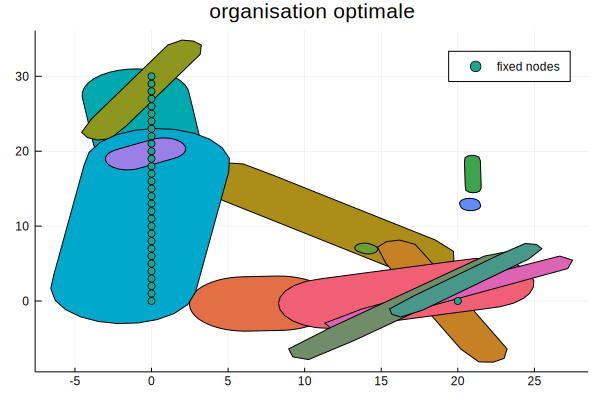

In [122]:
plot(xn[Shown_compo,:]', yn[Shown_compo,:]',seriestype=:shape, title = "organisation optimale", label = "")
scatter!(Xf,Yf, label = "fixed nodes",legend=:topright)

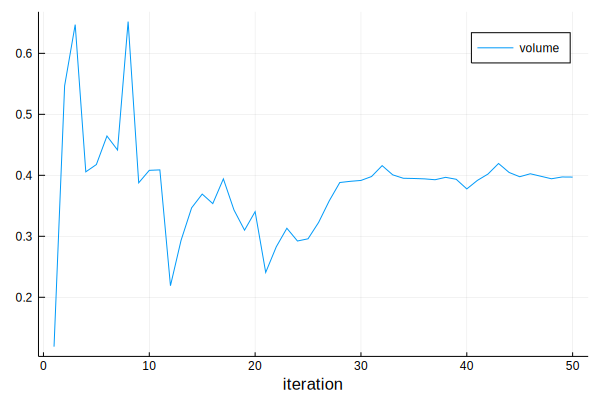

In [120]:
plot(1:outit,vvec,label = "volume", xlabel = "iteration")

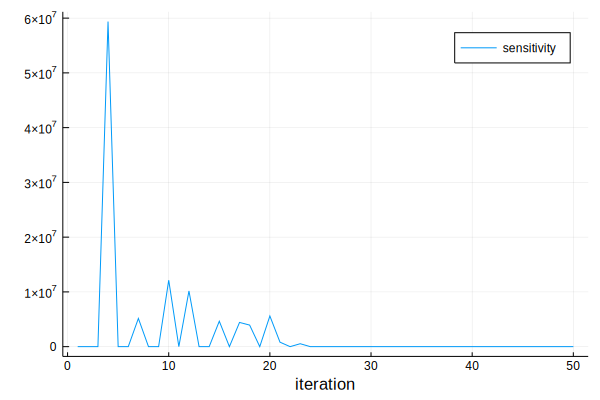

In [119]:
plot(1:outit,cvec,label = " sensitivity",xlabel = "iteration")